# Program Runs Machine Learning to Identify Best Feature for MSI Status

In [55]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import randint

# SciKit Learn Packages
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score

# Load the Dataframes

In [56]:
crispr_dataframe = pd.read_csv('CRISPRGeneEffect.csv')

sample_info = pd.read_csv('model_list_20240110.csv')

# Examine Sample Info Dataframe

In [57]:
sample_info.head(5)

,model_id,sample_id,patient_id,parent_id,model_name,synonyms,tissue,cancer_type,cancer_type_ncit_id,tissue_status,...,msh6_expression_by_ihc,braf_mutation_identified,braf_expression_by_ihc,pik3ca_mutation_identified,pten_expression_by_ihc,pten_mutation_identified,kras_mutation_identified,mismatch_repair_status,preoperative_ce_alevel,crispr_ko_data
0,SIDM01774,SIDS01659,SIDP01578,NaN,PK-59,NaN,Pancreas,Pancreatic Carcinoma,C3850,Metastasis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,SIDM00192,SIDS00612,SIDP00541,NaN,SNU-1033,NaN,Large Intestine,Colorectal Carcinoma,C9383,Tumour,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2,SIDM01447,SIDS01466,SIDP01347,NaN,SNU-466,NaN,Central Nervous System,Glioblastoma,C3058,Tumour,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,SIDM01554,SIDS01363,SIDP01247,NaN,IST-MES-2,NaN,Lung,Mesothelioma,C45662,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
4,SIDM01689,SIDS01631,SIDP01557,NaN,MUTZ-5,NaN,Haematopoietic and Lymphoid,B-Lymphoblastic Leukemia,C8644,Tumour,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


# Filter the Sample File for Specific Columns

In [58]:
filt_sample_info = sample_info[['BROAD_ID', 'cancer_type', 'msi_status']]
print (filt_sample_info.shape)
print ("")
filt_sample_info.head(5)

(2155, 3)



,BROAD_ID,cancer_type,msi_status
0,ACH-000205,Pancreatic Carcinoma,NaN
1,ACH-000286,Colorectal Carcinoma,NaN
2,ACH-000289,Glioblastoma,NaN
3,ACH-000331,Mesothelioma,NaN
4,ACH-000492,B-Lymphoblastic Leukemia,NaN


# Drop the NaNs from the Dataframe

In [59]:
filt_sample_info = filt_sample_info.dropna()
print (filt_sample_info.shape)
filt_sample_info.head(5)

(1032, 3)


,BROAD_ID,cancer_type,msi_status
10,ACH-000532,Colorectal Carcinoma,MSS
11,ACH-000402,Burkitt's Lymphoma,MSS
14,ACH-000999,Colorectal Carcinoma,MSI
15,ACH-000558,Glioblastoma,MSS
16,ACH-000838,Plasma Cell Myeloma,MSS


Note Lost about Half the Samples--- We Need Both ACH IDs and MSS-MSI Status for ML--- 

# Get the Counts from the Column

In [60]:
filt_sample_info['msi_status'].value_counts()

MSS    957
MSI     75
Name: msi_status, dtype: int64

# Create a Duplicate Column for Machine Learning (MSS vs MSI)

In [61]:
filt_sample_info['Labels'] = filt_sample_info.loc[:, 'msi_status']
filt_sample_info.head(5)

,BROAD_ID,cancer_type,msi_status,Labels
10,ACH-000532,Colorectal Carcinoma,MSS,MSS
11,ACH-000402,Burkitt's Lymphoma,MSS,MSS
14,ACH-000999,Colorectal Carcinoma,MSI,MSI
15,ACH-000558,Glioblastoma,MSS,MSS
16,ACH-000838,Plasma Cell Myeloma,MSS,MSS


# Re-Label the MSI Status to Zero and One

In [62]:
filt_sample_info["Labels"].replace({"MSS": 0, "MSI": 1}, inplace=True)
filt_sample_info.head(5)

,BROAD_ID,cancer_type,msi_status,Labels
10,ACH-000532,Colorectal Carcinoma,MSS,0
11,ACH-000402,Burkitt's Lymphoma,MSS,0
14,ACH-000999,Colorectal Carcinoma,MSI,1
15,ACH-000558,Glioblastoma,MSS,0
16,ACH-000838,Plasma Cell Myeloma,MSS,0


# Examine CRISPR Gene Effect File

In [63]:
print (crispr_dataframe.shape)
print ("")
print ("")
crispr_dataframe.head(5)

(1100, 18444)




,Unnamed: 0,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZWILCH (55055),ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
0,ACH-000001,-0.122637,0.025881,0.034217,-0.128082,-0.031285,0.338046,-0.006439,-0.093642,0.189186,...,-0.131727,-0.039829,0.179405,0.283552,0.204513,-0.289724,-0.062972,0.074180,0.111244,-0.467908
1,ACH-000004,0.019756,-0.083640,-0.060118,-0.027417,-0.036116,-0.001056,0.312876,-0.086897,0.204434,...,-0.170329,-0.454263,0.194583,0.098989,0.126948,0.032983,-0.410392,0.113156,0.234388,-0.088306
2,ACH-000005,-0.107208,-0.023211,0.200204,0.116039,-0.172227,-0.071294,0.203270,-0.127806,-0.090981,...,-0.301695,-0.454969,-0.061959,-0.036427,0.016602,-0.201273,-0.178877,-0.055349,-0.002161,-0.186842
3,ACH-000007,-0.031027,-0.137850,0.067704,0.107988,0.007992,0.124945,0.049548,-0.220824,-0.165669,...,-0.303390,-0.507272,-0.025400,0.236659,0.072010,-0.100344,-0.462160,-0.001555,-0.325964,-0.486660
4,ACH-000009,0.008888,-0.146566,0.084471,0.089419,0.065109,0.027841,0.087943,-0.161369,0.041121,...,-0.255466,-0.288739,-0.037132,0.261444,-0.062391,-0.112703,-0.598698,0.095877,-0.026742,-0.320759


In [64]:
# Get List of the Headers
column_headers = crispr_dataframe.columns.tolist()
#print (column_headers)

crispr_genes = column_headers[1:]
#print (crispr_genes)

# Examine CRISPR Gene Variance

In [65]:
variance_results = crispr_dataframe.var()
variance_results.to_csv("CRISPR_Gene_Effect_Variance.csv")

print (variance_results)

A1BG (1)            0.010899
A1CF (29974)        0.011160
A2M (2)             0.009393
A2ML1 (144568)      0.009988
A3GALT2 (127550)    0.015312
                      ...   
ZYG11A (440590)     0.009609
ZYG11B (79699)      0.016723
ZYX (7791)          0.016104
ZZEF1 (23140)       0.013737
ZZZ3 (26009)        0.028630
Length: 18443, dtype: float64


C:\Users\mjtom\AppData\Local\Temp\ipykernel_16936\715259853.py:1: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  variance_results = crispr_dataframe.var()


# Examine Histogram Spread of Data---Variance
Identify is there a good cut-off for variance--- remove extra features from the ML model

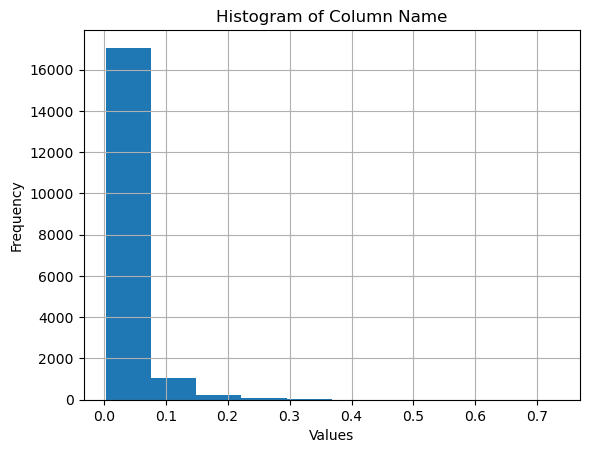

In [66]:
# Read the CSV file into a DataFrame
variance_df = pd.read_csv('CRISPR_Gene_Effect_Variance.csv')

# Plot a histogram of a single column in the DataFrame
variance_df.hist(column='0')

# Set the title and axis labels
plt.title('Histogram of Column Name')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

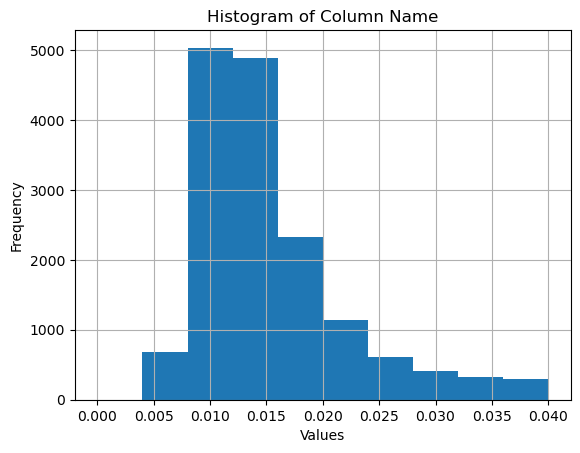

In [67]:
# Read the CSV file into a DataFrame
variance_df = pd.read_csv('CRISPR_Gene_Effect_Variance.csv')

# Plot a histogram of a single column in the DataFrame
variance_df.hist(column='0', range=[0, 0.04])

# Set the title and axis labels
plt.title('Histogram of Column Name')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

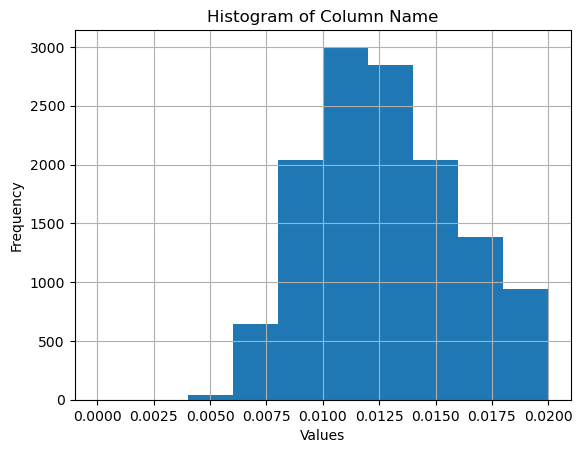

In [68]:
# Read the CSV file into a DataFrame
variance_df = pd.read_csv('CRISPR_Gene_Effect_Variance.csv')

# Plot a histogram of a single column in the DataFrame
variance_df.hist(column='0', range=[0, 0.02])

# Set the title and axis labels
plt.title('Histogram of Column Name')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

Based on the histogram data spread there appears to be a pile up below 0.02 for variance-- will filter values below this--

# Find ALL Genes With Low Variance <0.02

In [69]:
# Create a List of Genes to Remove
columns_to_remove = []

total_genes_initially = len(crispr_genes)
print ("Total Genes Initially: " + str(total_genes_initially))

# Loop Over the Variance Results
counter = 0
for variance in variance_results:
    #print (counter)
    gene_name = crispr_genes[counter]
    if variance < 0.02:
        columns_to_remove.append(gene_name)
        counter+=1
    else:  
        counter+=1
#print (columns_to_remove)
print ("Total Genes with Low Variance: " + str(len(columns_to_remove)))

Total Genes Initially: 18443
Total Genes with Low Variance: 12926


# Filter the CRISPR Data File

In [70]:
print ("Original Dataframe Shape")
print (crispr_dataframe.shape)

# Drop the Columns from the Dataframe
filt_crispr_dataframe = crispr_dataframe.drop(columns_to_remove, axis=1)
print ("Filtered Dataframe Shape")
print (filt_crispr_dataframe.shape)

Original Dataframe Shape
(1100, 18444)
Filtered Dataframe Shape
(1100, 5518)


# Remove Columns with NaNs from Gene Effect

In [71]:
filt_crispr_dataframe = filt_crispr_dataframe.dropna(axis=1)

print (filt_crispr_dataframe.shape)

(1100, 4813)


# Merge Dataframes for ML

In [72]:
merged_dataframe = pd.merge(filt_sample_info, filt_crispr_dataframe, how='inner', left_on='BROAD_ID', 
                            right_on='Unnamed: 0')

merged_dataframe.to_csv("Sample_Info_Filt_CRISPR_Gene_Effect.csv")

In [73]:
print (merged_dataframe.shape)
print ("")
print ("")
merged_dataframe.head(5)

(587, 4817)




,BROAD_ID,cancer_type,msi_status,Labels,Unnamed: 0,AAAS (8086),AAMP (14),AARS1 (16),AARS2 (57505),AASDHPPT (60496),...,ZPR1 (8882),ZRANB1 (54764),ZRANB2 (9406),ZRSR2 (8233),ZSWIM7 (125150),ZSWIM8 (23053),ZW10 (9183),ZWILCH (55055),ZWINT (11130),ZZZ3 (26009)
0,ACH-000532,Colorectal Carcinoma,MSS,0,ACH-000532,-0.104325,-0.933288,-1.820676,-0.372271,-0.050291,...,-1.407207,-0.276755,-0.309801,-1.237339,0.071687,-0.125052,0.041638,-0.133878,-0.671639,-0.186533
1,ACH-000402,Burkitt's Lymphoma,MSS,0,ACH-000402,-0.067873,-1.336848,-2.005842,-0.472146,-0.276306,...,-1.612893,0.029810,-0.739913,-0.835282,-0.333429,-0.096797,-0.209837,-0.346218,-0.137199,0.092261
2,ACH-000558,Glioblastoma,MSS,0,ACH-000558,-0.303328,-0.976429,-2.811766,-0.418374,-0.038853,...,-1.016217,0.079685,-0.233773,-0.298043,-0.076725,-0.087534,-0.050400,-0.380405,-0.307326,-0.235414
3,ACH-000838,Plasma Cell Myeloma,MSS,0,ACH-000838,-0.257031,-1.059695,-2.143211,-0.179661,-0.649330,...,-1.371773,-0.104347,-0.159808,-1.279215,0.082801,-0.380861,-0.295394,-0.262585,-0.782286,-0.215217
4,ACH-000667,Non-Small Cell Lung Carcinoma,MSS,0,ACH-000667,0.011899,-1.116389,-1.631972,-0.408868,-0.473531,...,-1.156481,-0.153457,-0.613195,-0.885288,-0.122854,-0.031501,0.081113,-0.067789,-0.732440,-0.519676


# See what MSS VS MSI Counts Are Now

In [74]:
merged_dataframe['msi_status'].value_counts()

MSS    534
MSI     53
Name: msi_status, dtype: int64

Warning--- MSI Status is Extremely Low--- So Model Will Struggle A lot with the Bias

# Get the Features and Target from the Dataframe

In [75]:
# Get List of the Headers
column_headers = merged_dataframe.columns.tolist()
#print (column_headers)
feature_columns = column_headers[5:]
#print (feature_columns)


y = merged_dataframe['Labels']
print (y)
print ("")
print ("")

X = merged_dataframe[feature_columns]
#print (X)
print ("The number of features are: " + str(len(feature_columns)))

0      0
1      0
2      0
3      0
4      0
      ..
582    0
583    0
584    1
585    0
586    0
Name: Labels, Length: 587, dtype: int64


The number of features are: 4812


# Create the Train Test Datasets

Turn on the Stratify Setting Because of the Class Imbalance Between Groups

In [88]:
# i.e. 70 % training dataset and 30 % test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, stratify=y, random_state=42)
print ("Done Setting Up Train Test Dataset")

Done Setting Up Train Test Dataset


In [89]:

# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 100)  
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train, y_train)
 
# performing predictions on the test dataset
y_pred = clf.predict(X_test)
 
# metrics are used to find accuracy or error
from sklearn import metrics  
print()
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL:", metrics.accuracy_score(y_test, y_pred))


ACCURACY OF THE MODEL: 0.9081632653061225


# Grid Search

In [90]:
param_grid = {
    'n_estimators': [50, 75, 100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 10, 15, 20],
}

print (param_grid)

{'n_estimators': [50, 75, 100, 200, 300, 400, 500], 'max_depth': [3, 5, 7, 10, 15, 20]}


In [91]:
print ("Running Random Forest with Grid Search")

rfc=RandomForestClassifier(random_state=42)

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
CV_rfc.fit(X_train, y_train)
print ("Done Running Grid Search")

Running Random Forest with Grid Search
Done Running Grid Search


In [92]:
CV_rfc.best_params_

{'max_depth': 3, 'n_estimators': 50}

In [93]:
best_max_grid_depth = (CV_rfc.best_params_['max_depth'])
best_n_grid_estimators = (CV_rfc.best_params_['n_estimators'])

print ("Best Max Grid Depth: " + str(best_max_grid_depth))
print ("Best Grid Estimator: " + str(best_n_grid_estimators))

Best Max Grid Depth: 3
Best Grid Estimator: 50


# Running the Random Forest with Best Parameters

In [171]:
# creating a RF classifier
clf = RandomForestClassifier(n_estimators=best_n_grid_estimators, max_depth=best_max_grid_depth )  
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train, y_train)
 
# performing predictions on the test dataset
y_pred = clf.predict(X_test)
 
# metrics are used to find accuracy or error
from sklearn import metrics  
print()
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL:", metrics.accuracy_score(y_test, y_pred))


ACCURACY OF THE MODEL: 0.9081632653061225


In [172]:
# Examine Feature Importance

# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances.head(25)

MIS18BP1 (55320)     0.019459
UFL1 (23376)         0.017650
RAD50 (10111)        0.013407
WRN (7486)           0.013237
SRRT (51593)         0.012902
FOXRED1 (55572)      0.012161
SRP19 (6728)         0.009968
BCLAF1 (9774)        0.009789
PPL (5493)           0.009555
IPO7 (10527)         0.009553
POU2F3 (25833)       0.009448
MEF2B (100271849)    0.009257
MCMBP (79892)        0.008795
INPP4A (3631)        0.008433
MARS2 (92935)        0.008405
H4C9 (8294)          0.008291
KIF20B (9585)        0.008194
RPL22L1 (200916)     0.007899
ASCC3 (10973)        0.007881
CEP350 (9857)        0.007810
SPOUT1 (51490)       0.007772
RPRD1B (58490)       0.007541
NT5C (30833)         0.007397
PIK3CD (5293)        0.007332
GZMB (3002)          0.007230
dtype: float64

# Evaluate the Model Using a Confusion Matrix

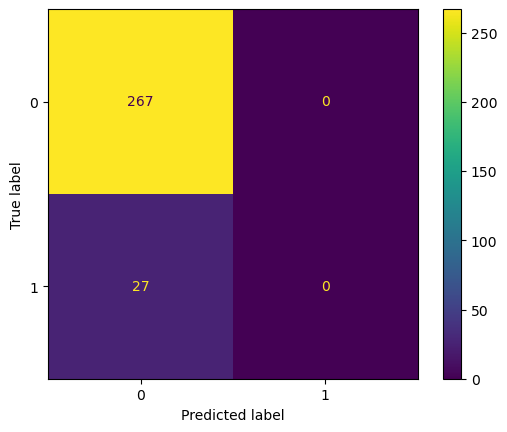

In [98]:
# Generate predictions with the best model
y_pred = clf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)


ConfusionMatrixDisplay(confusion_matrix=cm).plot();

# Finding the Specificity and Sensitivity

In [99]:
# Break Apart the Confusion Matrix To Get Values of Interest
true_positive = cm[0][0]
#print (true_positive)
false_positive = cm[0][1]
#print (false_positive)
false_negative = cm[1][0]
#print (false_negative)
true_negative = cm[1][1]
#print (true_negative)

sensitivity = true_positive / (true_positive + false_negative) * 100
#print (sensitivity)

specificity = true_negative / (false_positive + true_negative) * 100

print ("Sensitivity is: " + str(sensitivity))
print ("Specificity is: " + str(specificity))

Sensitivity is: 90.81632653061224
Specificity is: nan


C:\Users\mjtom\AppData\Local\Temp\ipykernel_16936\3157361007.py:14: RuntimeWarning: invalid value encountered in longlong_scalars
  specificity = true_negative / (false_positive + true_negative) * 100


# Calculate ROC AUC

In [101]:
# Get predicted class probabilities for the test set 
y_pred_prob = clf.predict_proba(X_test)[:, 1] 

In [102]:

# Compute the false positive rate (FPR)  
# and true positive rate (TPR) for different classification thresholds 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

In [103]:
# Compute the ROC AUC score 
roc_auc = roc_auc_score(y_test, y_pred_prob) 
roc_auc

0.7346372589818283

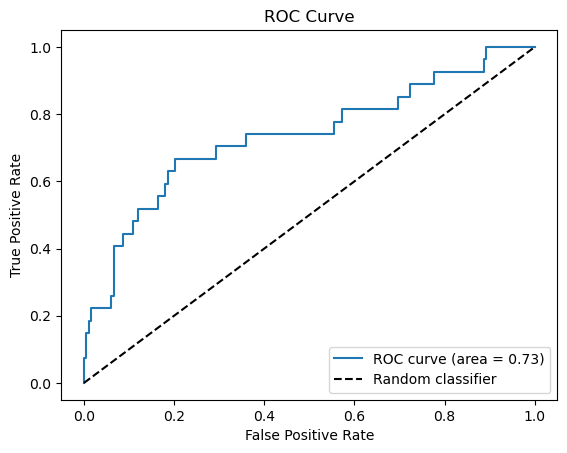

In [104]:
# Plot the ROC curve 
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc) 
# roc curve for tpr = fpr  
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier') 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC Curve') 
plt.legend(loc="lower right") 
plt.show()

# Overall Model Looks Decent--- Downfall is Sparsity of MSI Status
Goal is to re-run the model 10 times and determine the average of the features

# Creating Random States

In [108]:
# Creating a List of Random States to Build the Models
random_state_values = [*range(40, 50, 1)] 
print (random_state_values)
print ("Total Numbers: " + str(len(random_state_values)))


[40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Total Numbers: 10


In [179]:
random_state_value = np.random.seed(42)
print ("Random State Value " + str(random_state_value))

# i.e. 70 % training dataset and 30 % test datasets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, stratify=y, random_state=random_state_value)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, stratify=y, random_state=random_state_value)
print ("Done Setting Up Train Test Dataset")

# creating a RF classifier
clf = RandomForestClassifier(n_estimators=best_n_grid_estimators, max_depth=best_max_grid_depth )  
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train, y_train)
 
# performing predictions on the test dataset
y_pred = clf.predict(X_test)
 
# metrics are used to find accuracy or error
from sklearn import metrics  
print()
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL:", metrics.accuracy_score(y_test, y_pred))

# Examine Feature Importance

# Create a series containing feature importances from the model and feature names from the training data
feature_importance_run = "feature_importance_" + str(random_state_value)
feature_importance_run = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importance_run.head(10)

Random State Value None
Done Setting Up Train Test Dataset

ACCURACY OF THE MODEL: 0.9081632653061225


IRS2 (8660)          0.019912
FAM177A1 (283635)    0.017795
MIS18BP1 (55320)     0.015396
ZNF22 (7570)         0.014744
PELO (53918)         0.012359
DYNC1I2 (1781)       0.012262
TAF1B (9014)         0.011950
ADSL (158)           0.011355
RPL22L1 (200916)     0.010959
RAD50 (10111)        0.010668
dtype: float64

In [181]:
random_state_value = np.random.seed(43)

# i.e. 70 % training dataset and 30 % test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, stratify=y, random_state=random_state_value)
print ("Done Setting Up Train Test Dataset")

# creating a RF classifier
clf = RandomForestClassifier(n_estimators=best_n_grid_estimators, max_depth=best_max_grid_depth )  
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train, y_train)
 
# performing predictions on the test dataset
y_pred = clf.predict(X_test)
 
# metrics are used to find accuracy or error
from sklearn import metrics  
print()
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL:", metrics.accuracy_score(y_test, y_pred))

# Examine Feature Importance

# Create a series containing feature importances from the model and feature names from the training data
feature_importance_run = "feature_importance_" + str(random_state_value)
feature_importance_run = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importance_run.head(10)

Done Setting Up Train Test Dataset

ACCURACY OF THE MODEL: 0.9081632653061225


WRN (7486)          0.034515
DTX2 (113878)       0.017984
TIMM22 (29928)      0.012614
DRG1 (4733)         0.011474
UQCRQ (27089)       0.010544
COPS3 (8533)        0.009846
SLC25A33 (84275)    0.009732
CCT3 (7203)         0.009648
MAP2K1 (5604)       0.009425
ENTREP3 (10712)     0.009325
dtype: float64